In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import db_builder.db_handler as dbh
import logging

In [187]:
logging.getLogger('sqlalchemy').setLevel(logging.WARNING)

In [188]:
db_params = {
    'user': 'postgres',
    'password': input('Please enter DB pw'),  # enter your DB password
    'host': 'localhost',  # 'localhost' or IP address
    'port': '5432',  # '5432'
    'database': 'ttdatabase', #tensionTerminator
}

In [189]:
toolcheck = dbh.DB_Conn(db_params)
toolcheck.connect()
engine  = toolcheck.get_engine()

Connected to PostgreSQL, DB: ttdatabase


In [190]:
def table_to_df(tabel_name: str):
    return pd.read_sql_table(tabel_name, con=engine)

In [191]:
loop_df = table_to_df('loop')

2023-11-19 19:19:00,776 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-11-19 19:19:00,776 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-19 19:19:00,777 INFO sqlalchemy.engine.Engine select current_schema()
2023-11-19 19:19:00,778 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-19 19:19:00,779 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-11-19 19:19:00,779 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-11-19 19:19:00,780 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-19 19:19:00,781 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

table_name = 'loop'  # Replace 'your_table_name' with the actual name of the table
df = pd.read_sql_table(table_name, con=engine)

In [192]:
loop_df

,id,timestamp,session_length,location,human_labeled,user_id
0,1,2023-09-08 19:12:12.778376,116,MCI,True,6
1,2,2023-09-08 19:15:23.051845,132,MCI,True,4
2,3,2023-09-08 19:20:38.981489,54,MCI,True,2
3,4,2023-09-08 19:21:18.026639,98,MCI,True,10
4,5,2023-09-08 19:23:23.087926,101,MCI,True,5
...,...,...,...,...,...,...
145,138,2023-10-13 13:51:47.120519,117,MCI,False,1
146,139,2023-10-13 13:54:25.457495,133,MCI,False,1
147,143,2023-10-13 14:10:20.140994,203,MCI,False,1
148,141,2023-10-13 14:00:08.397570,162,MCI,False,1


In [193]:
def overview():
    print(f"Die DB enthält {loop_df['timestamp'].count()} Aufzeichnungen, das entspricht {loop_df['session_length'].sum()} Sekunden an Videomaterial:")
    print(f"\t{loop_df['human_labeled'].sum()} Aufzeichnungen sind von Menschen gelabelt ({loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()} Sekunden) ")
    print(f"\t{(loop_df['human_labeled'] == False).sum()} Aufzeichnungen sind von Menschen gelabelt ({loop_df.loc[loop_df['human_labeled'] == False, 'session_length'].sum()} Sekunden)")
    print(f"Videolänge mean: {loop_df['session_length'].mean()} Sekunden")
    print(f"Videolänge median: {loop_df['session_length'].median()} Sekunden")
    print(f"Videolänge min: {loop_df['session_length'].min()} Sekunden")
    print(f"Videolänge max: {loop_df['session_length'].max()} Sekunden")

In [194]:
overview()

Die DB enthält 150 Aufzeichnungen, das entspricht 8583 Sekunden an Videomaterial:
	128 Aufzeichnungen sind von Menschen gelabelt (5987 Sekunden) 
	22 Aufzeichnungen sind von Menschen gelabelt (2596 Sekunden)
Videolänge mean: 57.22 Sekunden
Videolänge median: 44.5 Sekunden
Videolänge min: 5 Sekunden
Videolänge max: 203 Sekunden


In [195]:
grouped_df = loop_df.groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()

In [196]:
grouped_df['labeled'] = loop_df[loop_df['human_labeled'] == True].groupby(loop_df['timestamp'].dt.date)['session_length'].sum().reset_index()['session_length']



In [197]:
grouped_df = grouped_df.fillna(0)

In [198]:
grouped_df

,timestamp,session_length,labeled
0,2023-09-08,1961,1961.0
1,2023-09-18,4026,4026.0
2,2023-10-13,2596,0.0


In [199]:
loop_df.loc[loop_df['human_labeled'] == True, 'session_length'].sum()

5987

In [200]:
grouped_df['session_length']/60

0    32.683333
1    67.100000
2    43.266667
Name: session_length, dtype: float64

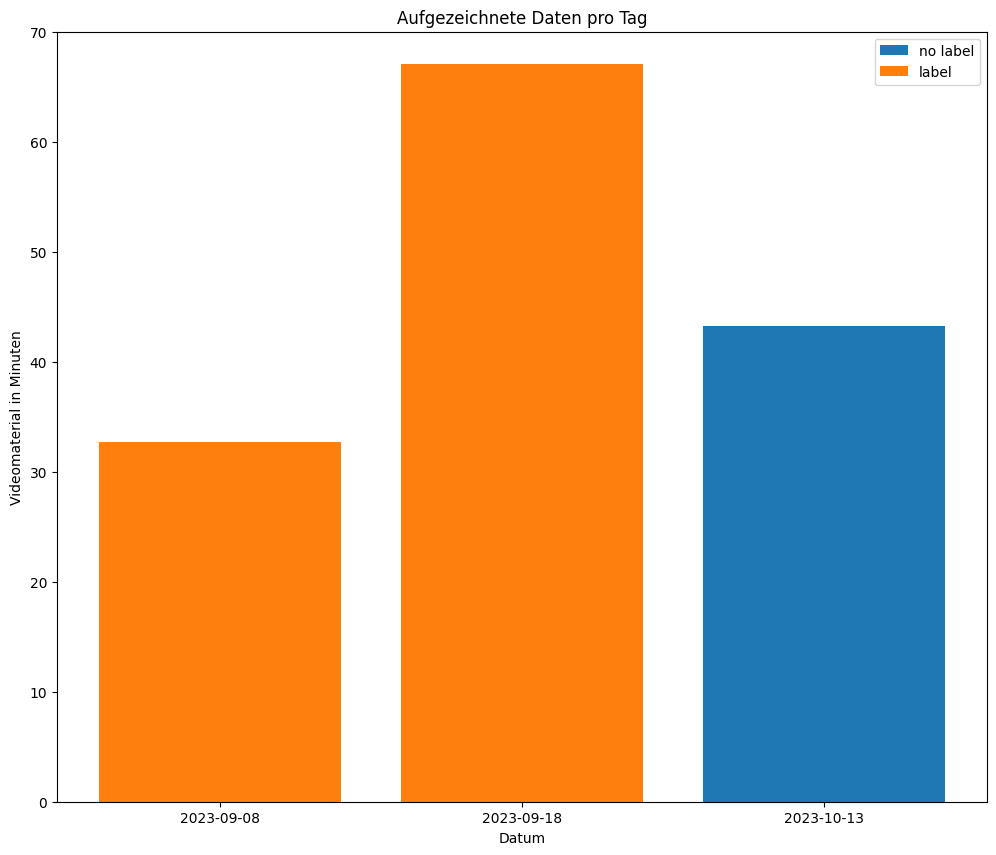

In [201]:
label = ['label', 'no lable']
plt.figure(figsize=(12, 10))

plt.bar(grouped_df['timestamp'].astype(str), grouped_df['session_length']/60, label='no label')
plt.bar(grouped_df['timestamp'].astype(str), grouped_df['labeled']/60, label='label')
plt.xlabel('Datum')
plt.ylabel('Videomaterial in Minuten')
plt.title('Aufgezeichnete Daten pro Tag')
plt.ylim(0,70)
plt.legend()

plt.show()



In [202]:
loop_df

,id,timestamp,session_length,location,human_labeled,user_id
0,1,2023-09-08 19:12:12.778376,116,MCI,True,6
1,2,2023-09-08 19:15:23.051845,132,MCI,True,4
2,3,2023-09-08 19:20:38.981489,54,MCI,True,2
3,4,2023-09-08 19:21:18.026639,98,MCI,True,10
4,5,2023-09-08 19:23:23.087926,101,MCI,True,5
...,...,...,...,...,...,...
145,138,2023-10-13 13:51:47.120519,117,MCI,False,1
146,139,2023-10-13 13:54:25.457495,133,MCI,False,1
147,143,2023-10-13 14:10:20.140994,203,MCI,False,1
148,141,2023-10-13 14:00:08.397570,162,MCI,False,1


In [203]:
session_user_id_df_test = loop_df.groupby(loop_df['timestamp'].dt.date)['user_id'].unique()

In [204]:
session_user_id_df_test

timestamp
2023-09-08    [6, 4, 2, 10, 5, 8, 3, 7, 9, 11]
2023-09-18                        [6, 7, 9, 4]
2023-10-13                                 [1]
Name: user_id, dtype: object

In [205]:
session_user_id_df_test1 = loop_df.groupby([loop_df['timestamp'].dt.date, 'user_id']).size().unstack(fill_value=0)

In [206]:
session_user_id_df_test1

user_id,1,2,3,4,5,6,7,8,9,10,11
timestamp,,,,,,,,,,,
2023-09-08,0,2,4,5,3,5,2,3,2,2,1
2023-09-18,0,0,0,27,0,35,35,0,2,0,0
2023-10-13,22,0,0,0,0,0,0,0,0,0,0


In [207]:
session_user_time_df = loop_df.groupby([loop_df['timestamp'].dt.date, 'user_id'])['session_length'].sum().unstack(fill_value=0)

In [208]:
session_user_time_df = session_user_time_df.reset_index()

In [209]:
session_user_time_df

user_id,timestamp,1,2,3,4,5,6,7,8,9,10,11
0,2023-09-08,0,115,243,267,207,327,92,197,291,192,30
1,2023-09-18,0,0,0,1158,0,1479,1317,0,72,0,0
2,2023-10-13,2596,0,0,0,0,0,0,0,0,0,0


In [210]:
users_df = table_to_df('users')

2023-11-19 19:19:01,123 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-19 19:19:01,124 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2023-11-19 19:19:01,124 INFO sqlalchemy.engine.Engine [cached since 0.3435s ago] {'table_name': 'users', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2023-11-19 19:19:01,126 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_

In [212]:
def get_user(id):
    user_df = table_to_df('users')
    users_loc = user_df.loc[user_df['id']==id].values
    return f"{users_loc[0][1]} {users_loc[0][2]}"

2023-11-19 19:19:01,176 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-11-19 19:19:01,176 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname_1)s
2023-11-19 19:19:01,177 INFO sqlalchemy.engine.Engine [cached since 0.3957s ago] {'table_name': 'users', 'param_1': 'r', 'param_2': 'p', 'param_3': 'f', 'param_4': 'v', 'param_5': 'm', 'nspname_1': 'pg_catalog'}
2023-11-19 19:19:01,178 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_

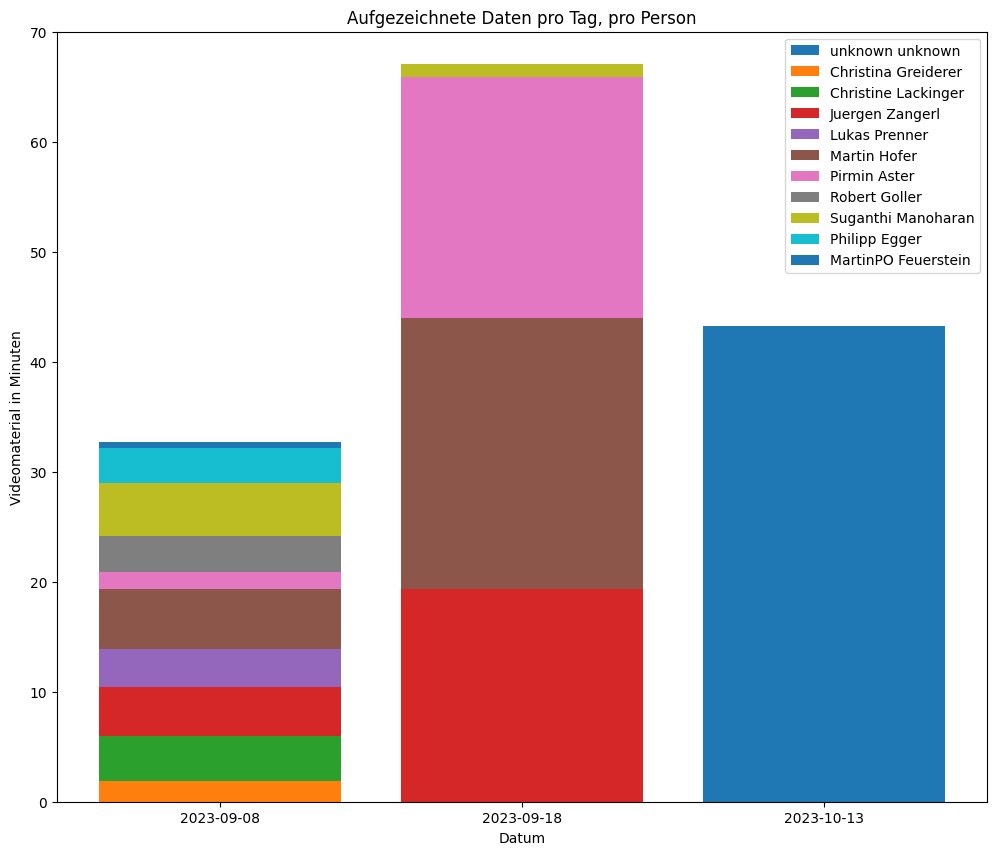

In [214]:
#label = ['label', 'no lable']
plt.figure(figsize=(12, 10))
bottom = np.zeros(3)

for x in range(loop_df['user_id'].nunique()):
    plt.bar(session_user_time_df['timestamp'].astype(str), session_user_time_df[x+1]/60, label=f"{get_user(x+1)}", bottom=bottom)
    bottom += session_user_time_df[x+1]/60
#plt.bar(grouped_df['timestamp'].astype(str), grouped_df['labeled']/60, label='label')
plt.xlabel('Datum')
plt.ylabel('Videomaterial in Minuten')
plt.ylim(0,70)
plt.title('Aufgezeichnete Daten pro Tag, pro Person')
plt.legend()

plt.show()